In [2]:
import numpy as np
import pandas as pd
import glob
import h5py
import os
import cv2
import math
import time
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

from tqdm import tqdm

# Data type evaluation
* [numpy.iinfo()](https://numpy.org/doc/stable/reference/generated/numpy.iinfo.html)
* [numpy.finfo()](https://numpy.org/doc/stable/reference/generated/numpy.finfo.html)

In [3]:
intInfo = np.iinfo(np.uint8)
print("float info")
print("- bits\t\t", f"{intInfo.bits} bits")
print("- range\t\t",f"{intInfo.min} to {intInfo.max}")

float info
- bits		 8 bits
- range		 0 to 255


In [4]:
# ref: 
floatInfo = np.finfo(np.float16)
print("float info")
print("- bits\t\t", f"{floatInfo.bits} bits")
print("- range\t\t",f"{floatInfo.min} to {floatInfo.max}")
print("- precision\t",f"{floatInfo.precision} decimal digits "  )

float info
- bits		 16 bits
- range		 -65504.0 to 65504.0
- precision	 3 decimal digits 


# loading data into np.array 

In [5]:
# loading labels from csv file
df = pd.read_csv("Datasets/labels.csv")

# create dictionary of unique breeds with its respective id
# sort the list as required by evaluation on the test set
breeds = sorted(df.breed.unique())
dict_breeds = dict(zip(breeds, range(len(breeds))))

# add duplicate column
df["breed_id"] = df.breed
# convert duplicated column as unique id
df = df.replace({"breed_id":dict_breeds})

print("Shape\t\t: {}".format(df.shape))
print("Unique labels\t: {}".format(len(breeds)))

Shape		: (10222, 3)
Unique labels	: 120


In [6]:
# check if dictionary is in order
dict_breeds

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [7]:
# to make sure the breed_id has already been sorted to alphabetical order
df.head()

id             breed  breed_id
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull        19
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo        37
2  001cdf01b096e06d78e9e5112d419397          pekinese        85
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick        15
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever        49

In [8]:
INPUT_SHAPE = (192,192,3)

In [9]:
data = []
labels = []

# collect all files from directory into a list
image_files_train = [f for f in glob.glob("Datasets/train" + "/**/*", recursive=True) if not os.path.isdir(f)]
print("{} files found!".format(len(image_files_train)))

# create groud-truth label from the image path
print("loading images")
t = time.time()
for img in tqdm(image_files_train):
    img_file = os.path.basename(img)
    name = img_file.split(".")[0]

    # check if image file has a record in given labels
    result = df.loc[df['id'] == name]
    if result.empty:
        print("LABEL NOT FOUND: {}".format(name))
        continue
    else:
        image_ = load_img(img,target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))
        image = np.asarray(image_)
        data.append(image)
        
        # read respective unique breed id from result 
        label = result['breed_id'].iloc[0]
        labels.append([label])
# one-hot the to categorical
labels = to_categorical(labels)       
print(f'Time taken to load images: {time.time()-t}')

# pre-processing (normalisation)
print("pre-processing")
t = time.time()
data = np.array(data, dtype=np.float16) / 255.0
labels = np.array(labels, dtype=np.uint8)
print(f'Time taken to pre-processing: {time.time()-t}')

print('x_data shape:', data.shape)
print('y_data shape:', labels.shape)

  0%|                                                                                        | 0/10222 [00:00<?, ?it/s]

10222 files found!
loading images


100%|████████████████████████████████████████████████████████████████████████████| 10222/10222 [02:03<00:00, 82.97it/s]


Time taken to load images: 123.31270003318787
pre-processing
Time taken to pre-processing: 24.095016956329346
x_data shape: (10222, 192, 192, 3)
y_data shape: (10222, 120)


In [10]:
data[50]

array([[[0.6904 , 0.639  , 0.5728 ],
        [0.5806 , 0.5293 , 0.4626 ],
        [0.298  , 0.2471 , 0.1843 ],
        ...,
        [0.3098 , 0.2705 , 0.2354 ],
        [0.4275 , 0.3687 , 0.3882 ],
        [0.298  , 0.2274 , 0.2744 ]],

       [[0.6587 , 0.608  , 0.541  ],
        [0.5884 , 0.537  , 0.4707 ],
        [0.3137 , 0.2627 , 0.2    ],
        ...,
        [0.4863 , 0.447  , 0.408  ],
        [0.392  , 0.3333 , 0.3452 ],
        [0.341  , 0.2744 , 0.3137 ]],

       [[0.5176 , 0.4548 , 0.392  ],
        [0.569  , 0.506  , 0.443  ],
        [0.2783 , 0.2274 , 0.1647 ],
        ...,
        [0.6    , 0.565  , 0.498  ],
        [0.4158 , 0.3647 , 0.341  ],
        [0.2157 , 0.153  , 0.1569 ]],

       ...,

       [[0.3137 , 0.2471 , 0.2079 ],
        [0.298  , 0.2432 , 0.2079 ],
        [0.0863 , 0.04706, 0.00784],
        ...,
        [0.9766 , 0.9253 , 0.8    ],
        [0.9844 , 0.929  , 0.8237 ],
        [1.     , 0.9453 , 0.8433 ]],

       [[0.349  , 0.2825 , 0.2432 ],
  

In [11]:
labels[50]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [12]:
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

def nparray_info(header, nparr):
    print(header)
    print("-  shape\t", nparr.shape)
    print("-  dtype\t", nparr.dtype)
    print("- nbytes\t", f"{nparr.nbytes} ({convert_size(nparr.nbytes)})")
    

In [13]:
# print out shape, dtype and data size
nparray_info("Images", data)
print()
nparray_info("Labels", labels)

Images
-  shape	 (10222, 192, 192, 3)
-  dtype	 float16
- nbytes	 2260942848 (2.11 GB)

Labels
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


### loading and saving with .npz
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)





In [14]:
# saving
saving_path = "./Datasets/preprocessed_data_{}x{}.npz".format(INPUT_SHAPE[0], INPUT_SHAPE[1])

print("Saving to npz file")
# ensure directory is created before save data file
os.makedirs(os.path.dirname(saving_path), exist_ok=True)
t = time.time()
np.savez_compressed(saving_path, X=data, Y=labels)
print(f'Time taken to save compressed data: {time.time()-t}')

Saving to npz file
Time taken to save compressed data: 239.0082242488861


In [15]:
# test the loading of npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(saving_path)
print(loaded.files)
loaded_X = loaded["X"]
loaded_Y = loaded["Y"]
print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X', 'Y']
Time taken to load compressed data: 25.397099494934082


In [16]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X)
print()
nparray_info("Labels (npz)", loaded_Y)

Images (npz)
-  shape	 (10222, 192, 192, 3)
-  dtype	 float16
- nbytes	 2260942848 (2.11 GB)

Labels (npz)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [24]:
# ensure correctness of data
assert labels.dtype == loaded_Y.dtype
assert (labels==loaded_Y).all()


assert data.dtype == loaded_X.dtype
assert np.allclose(data, loaded_X)
assert (data==loaded_X).all()

In [17]:
loaded_Y[50]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

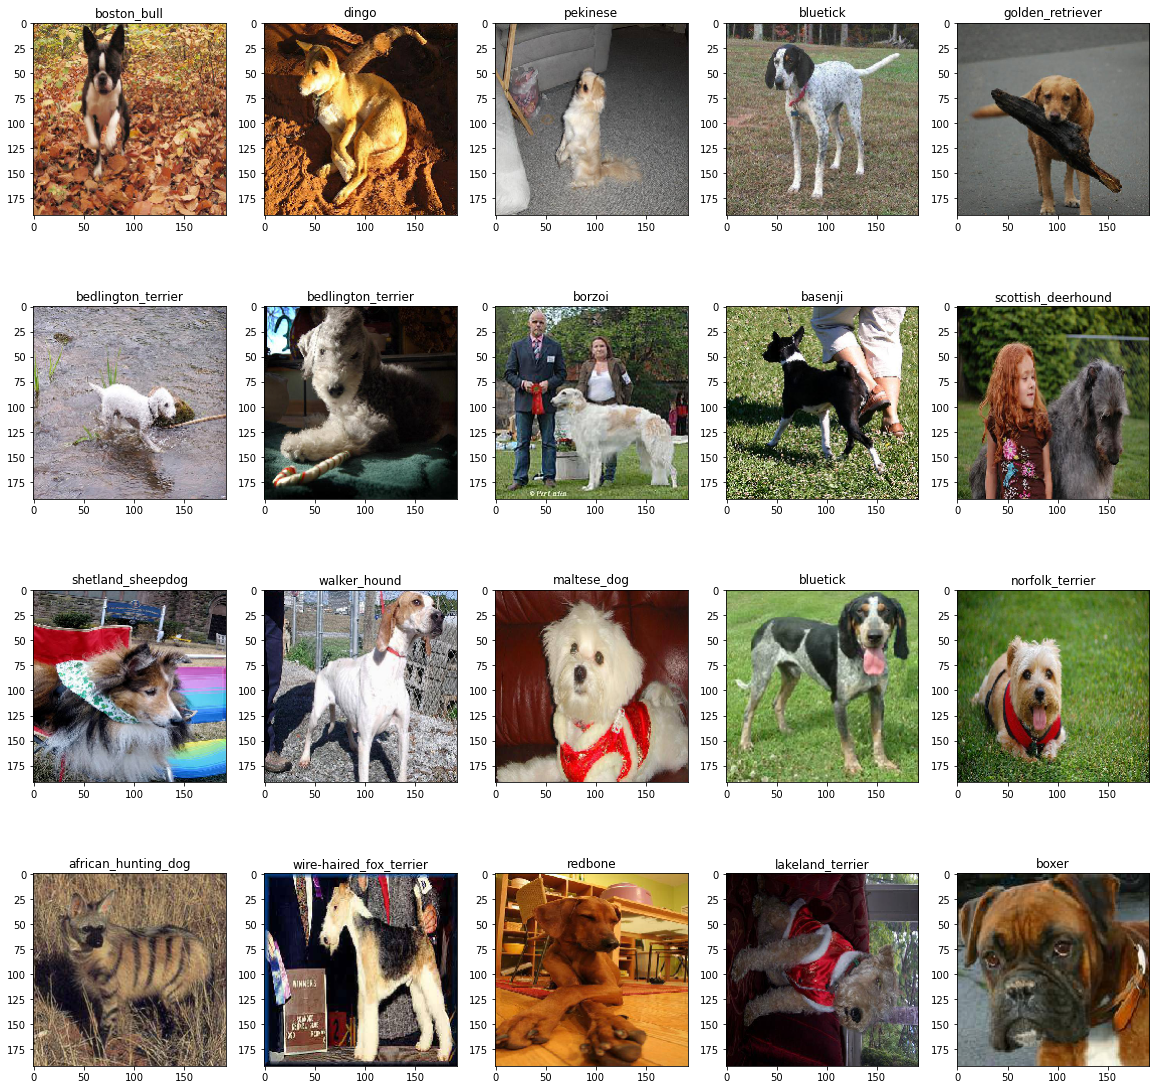

In [18]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.title(breeds[np.where(loaded_Y[i]==1)[0][0]])
    plt.imshow(loaded_X[i].astype('float32'))

### loading and saving with h5 format
* [h5py.creating-datasets()](https://docs.h5py.org/en/stable/high/dataset.html#creating-datasets)
* [lossless compression](https://docs.h5py.org/en/stable/high/dataset.html#lossless-compression-filters)



In [99]:
def generate_h5_data(data, labels, file_path="./Datasets/data.h5"):
    assert(type(file_path) is str)
    assert(len(data) == len(labels))
    
    os.makedirs(os.path.dirname(saving_path), exist_ok=True)
    try:
        with h5py.File(file_path, 'w') as h5:
            h5.create_dataset('image', data= data, compression="gzip", compression_opts=9)
            h5.create_dataset('label', data= labels)
    except Exception as e:
        print(e)
    

def load_h5_data(file_path):
    try:
        with h5py.File(file_path, "r") as h5:
            print("h5.keys", h5.keys())
            data = np.array(h5['image'][:])
            labels = np.array(h5['label'][:])
        print("The shape of x_field",data.shape)
        print("The shape of y_field",labels.shape)
    except Exception as e:
        print(e)
    return data, labels

In [100]:
saving_path = "./Datasets/preprocessed_data_{}x{}.h5".format(INPUT_SHAPE[0], INPUT_SHAPE[1])

t = time.time()
generate_h5_data(data, labels, saving_path)
print(f'Time taken to save compressed data: {time.time()-t}')

Time taken to save compressed data: 98.54022455215454


In [101]:
print("loading from h5 file")
t = time.time()
loaded_X, loaded_Y = load_h5_data(saving_path)
print(f'Time taken to load compressed data: {time.time()-t}')

loading from h5 file
h5.keys KeysView(<HDF5 file "preprocessed_data_128x128.h5" (mode r)>)
The shape of x_field (10222, 128, 128, 3)
The shape of y_field (10222, 120)
Time taken to load compressed data: 12.521141767501831


In [102]:
# print out shape, dtype and data size
nparray_info("Images (h5)", loaded_X)
print()
nparray_info("Labels (h5)", loaded_Y)

Images (h5)
-  shape	 (10222, 128, 128, 3)
-  dtype	 float16
- nbytes	 1004863488 (958.31 MB)

Labels (h5)
-  shape	 (10222, 120)
-  dtype	 uint8
- nbytes	 1226640 (1.17 MB)


In [23]:
# ensure correctness of data
assert labels.dtype == loaded_Y.dtype
assert (labels==loaded_Y).all()


assert data.dtype == loaded_X.dtype
assert np.allclose(data, loaded_X)
assert (data==loaded_X).all()

## Do likewise for the test dataset but w/o any label

In [ ]:
INPUT_SHAPE = (192,192,3)

In [37]:
data_test = []

# collect all files from directory into a list
image_files_test = [f for f in glob.glob("Datasets/test" + "/**/*", recursive=True) if not os.path.isdir(f)]
print("{} files found!".format(len(image_files_test)))

# create groud-truth label from the image path
print("loading images")
t = time.time()
for img in tqdm(image_files_test):
    img_file = os.path.basename(img)
    name = img_file.split(".")[0]

    image_ = load_img(img,target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]))
    image = np.asarray(image_)
    data_test.append(image)
     
print(f'Time taken to load images: {time.time()-t}')

# pre-processing (normalisation)
print("pre-processing")
t = time.time()
data_test = np.array(data_test, dtype=np.float16) / 255.0
#labels = np.array(labels, dtype=np.uint8)
print(f'Time taken to pre-processing: {time.time()-t}')

print('x_data shape:', data_test.shape)
#print('y_data shape:', labels.shape)

  1%|▌                                                                             | 79/10357 [00:00<00:13, 759.65it/s]

10357 files found!
loading images


100%|███████████████████████████████████████████████████████████████████████████| 10357/10357 [00:22<00:00, 467.75it/s]


Time taken to load images: 22.14509630203247
pre-processing
Time taken to pre-processing: 7.88922643661499
x_data shape: (10357, 128, 128, 3)


In [38]:
data_test[50]

array([[[0.153  , 0.153  , 0.153  ],
        [0.0745 , 0.0745 , 0.0745 ],
        [0.1059 , 0.1059 , 0.1059 ],
        ...,
        [0.0353 , 0.0392 , 0.00784],
        [0.     , 0.00392, 0.     ],
        [0.098  , 0.098  , 0.0902 ]],

       [[0.1608 , 0.1608 , 0.1608 ],
        [0.08234, 0.08234, 0.08234],
        [0.1177 , 0.1177 , 0.1177 ],
        ...,
        [0.04315, 0.04706, 0.01569],
        [0.02745, 0.03137, 0.00784],
        [0.08234, 0.08234, 0.0745 ]],

       [[0.1647 , 0.1647 , 0.1647 ],
        [0.08234, 0.08234, 0.08234],
        [0.1137 , 0.1137 , 0.1137 ],
        ...,
        [0.1255 , 0.1294 , 0.098  ],
        [0.102  , 0.1059 , 0.08234],
        [0.1137 , 0.1137 , 0.1059 ]],

       ...,

       [[0.953  , 0.7607 , 0.784  ],
        [0.7607 , 0.541  , 0.545  ],
        [0.8784 , 0.651  , 0.643  ],
        ...,
        [0.3804 , 0.4941 , 0.6196 ],
        [0.4587 , 0.5728 , 0.698  ],
        [0.4666 , 0.5806 , 0.706  ]],

       [[0.898  , 0.757  , 0.8115 ],
  

In [39]:
# print out shape, dtype and data size
nparray_info("Images", data_test)

Images
-  shape	 (10357, 128, 128, 3)
-  dtype	 float16
- nbytes	 1018134528 (970.97 MB)


### loading and saving with .npz
* [np.save()](https://numpy.org/doc/stable/reference/generated/numpy.save.html)
* [np.savez()](https://numpy.org/doc/stable/reference/generated/numpy.savez.html)
* [np.savez_compressed()](https://numpy.org/doc/stable/reference/generated/numpy.savez_compressed.html)
* [np.lib.format](https://numpy.org/doc/stable/reference/generated/numpy.lib.format.html)

In [40]:
# saving
saving_path = "./Datasets/preprocessed_data_test_{}x{}.npz".format(INPUT_SHAPE[0], INPUT_SHAPE[1])

print("Saving to npz file")
# ensure directory is created before save data file
os.makedirs(os.path.dirname(saving_path), exist_ok=True)
t = time.time()
np.savez_compressed(saving_path, X=data_test)
print(f'Time taken to save compressed data: {time.time()-t}')

Saving to npz file
Time taken to save compressed data: 87.92499685287476


In [41]:
# test the loading of npz file
print("Loading from npz file")
t = time.time()
loaded = np.load(saving_path)
print(loaded.files)
loaded_X_test = loaded["X"]
print(f'Time taken to load compressed data: {time.time()-t}')

Loading from npz file
['X']
Time taken to load compressed data: 6.599689960479736


In [43]:
# print out shape, dtype and data size
nparray_info("Images (npz)", loaded_X_test)

Images (npz)
-  shape	 (10357, 128, 128, 3)
-  dtype	 float16
- nbytes	 1018134528 (970.97 MB)


In [46]:
# ensure correctness of data
assert data_test.dtype == loaded_X_test.dtype
assert np.allclose(data_test, loaded_X_test)
assert (data_test==loaded_X_test).all()

In [82]:
loaded_X_test[50][0]

array([[0.153  , 0.153  , 0.153  ],
       [0.0745 , 0.0745 , 0.0745 ],
       [0.1059 , 0.1059 , 0.1059 ],
       [0.0902 , 0.0902 , 0.0902 ],
       [0.098  , 0.098  , 0.098  ],
       [0.0902 , 0.0902 , 0.0902 ],
       [0.1137 , 0.1137 , 0.1137 ],
       [0.1137 , 0.1137 , 0.1137 ],
       [0.08234, 0.08234, 0.08234],
       [0.0706 , 0.0706 , 0.0706 ],
       [0.0706 , 0.0706 , 0.0706 ],
       [0.0706 , 0.0706 , 0.0706 ],
       [0.0784 , 0.0784 , 0.0784 ],
       [0.0784 , 0.0784 , 0.0784 ],
       [0.06274, 0.06274, 0.06274],
       [0.051  , 0.051  , 0.051  ],
       [0.0549 , 0.0549 , 0.0549 ],
       [0.02353, 0.02353, 0.02353],
       [0.04315, 0.04315, 0.04315],
       [0.0549 , 0.0549 , 0.0549 ],
       [0.0706 , 0.0706 , 0.0706 ],
       [0.0706 , 0.0706 , 0.0706 ],
       [0.0745 , 0.06665, 0.0706 ],
       [0.1098 , 0.0863 , 0.0941 ],
       [0.102  , 0.0784 , 0.0863 ],
       [0.102  , 0.08234, 0.098  ],
       [0.098  , 0.0902 , 0.102  ],
       [0.08234, 0.0745 , 0.

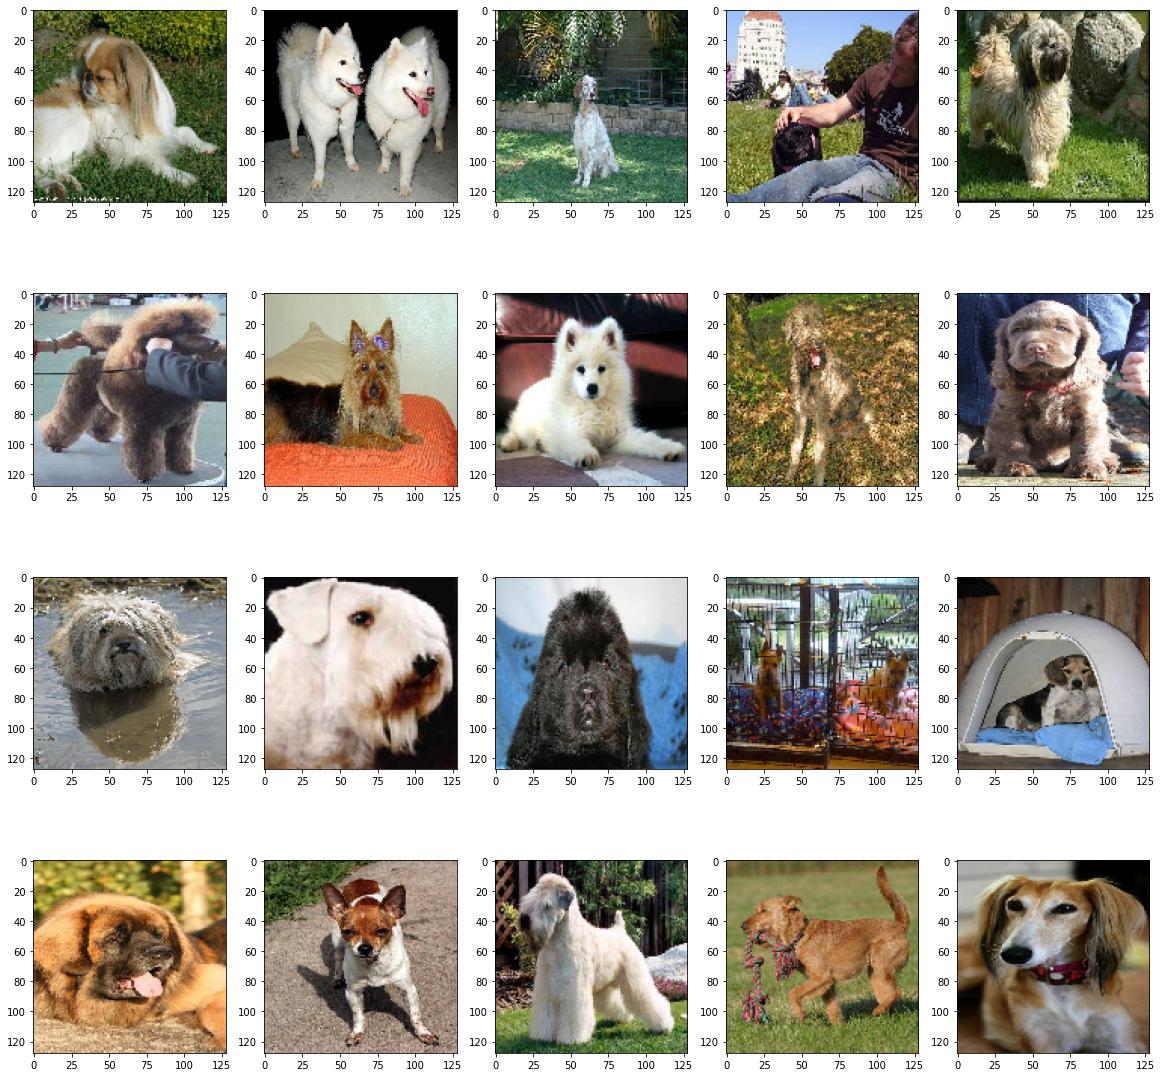

In [48]:
# check the data
N = 20

plt.figure(figsize=(20,20))
for i in range(N):
    ax = plt.subplot(int(N/5),5,i+1)
    plt.imshow(loaded_X_test[i].astype('float32'))